In [1]:
#!g1.1
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
from scipy.spatial.distance import directed_hausdorff
from monai.metrics.utils import get_mask_edges, get_surface_distance

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/usr/local/lib/python3.8/dist-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
#!g1.1
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Train pipeline ver 13.3'
    comment       = 'Unet pipeLine 13.3 loss [bce 0.33,dice 0.33, tversky 0.33] 224x224x1 efb0 bs128 fold 0'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b0'
    postfix       = 'lr_plt_aug3'
    train_bs      = 128
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 30
    lr            = 2e-3
    scheduler     = 'ReduceLROnPlateau'
    aug           = 'train_aug3'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    folds         = [0]
    num_classes   = 3
    input_chnls   = 1
    val_freq      = 2
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#!g1.1
OUTPUT_DIR = '/home/jupyter/work/resources/output/'
WORK_DIR='/home/jupyter/work/resources/'
DATASET_DIR='/home/jupyter/mnt/datasets/uw_dataset/'
EXPERIMENT= f'{CFG.model_name}_{CFG.backbone}_{CFG.img_size[0]}_{CFG.img_size[1]}_{CFG.input_chnls}_{CFG.postfix}'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'

!!mkdir {OUTPUT_DIR}
!!mkdir {EXPERIMENT_DIR}

['mkdir: cannot create directory ‘/home/jupyter/work/resources/output/Unet_efficientnet-b0_224_224_1_lr_plt_aug3/’: File exists']

In [4]:
#!g1.1
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [341]:
#!g1.1
df = pd.read_csv(DATASET_DIR+'train.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['resized_mask_path'] = df.resized_mask_path.str.replace('/png_mask','/np_mask').str.replace('.png','.npy')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks

df['resized_img_path'] = df.resized_img_path.str.replace("/kaggle/input/uwmgi-mask-dataset/",DATASET_DIR)
df['resized_mask_path'] = df.resized_mask_path.str.replace("/kaggle/input/uwmgi-mask-dataset/",DATASET_DIR)
fault1 = 'case7_day0'
fault2 = 'case81_day30'
df = df[~df['id'].str.contains(fault1) & ~df['id'].str.contains(fault2)].reset_index(drop=True)
df.head(1)

id  case  day  slice  \
0  case123_day20_slice_0001   123   20      1   

                                          image_path  height  width  \
0  /kaggle/input/uw-madison-gi-tract-image-segmen...     266    266   

                                   resized_mask_path  \
0  /home/jupyter/mnt/datasets/uw_dataset/np_mask/...   

                                    resized_img_path segmentation  rle_len  \
0  /home/jupyter/mnt/datasets/uw_dataset/png_img/...       [, , ]        0   

   empty  
0   True

In [196]:
#!g1.1
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, CFG.input_chnls]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk
    

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

In [7]:
#!g1.1
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    3374
      True     4706
1.0   False    4112
      True     4896
2.0   False    2973
      True     3827
3.0   False    3407
      True     4689
4.0   False    2627
      True     3597
Name: id, dtype: int64

In [8]:
#!g1.1
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['resized_img_path'].tolist()
        self.msk_paths  = df['resized_mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return img_path,msk_path,torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

In [9]:
#!g1.1
def prepare_loaders(fold, debug=False):
    
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        
        valid_df = valid_df.head(32*3).query("empty==0")
   
    valid_dataset = BuildDataset(valid_df, transforms=None)
    
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return valid_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


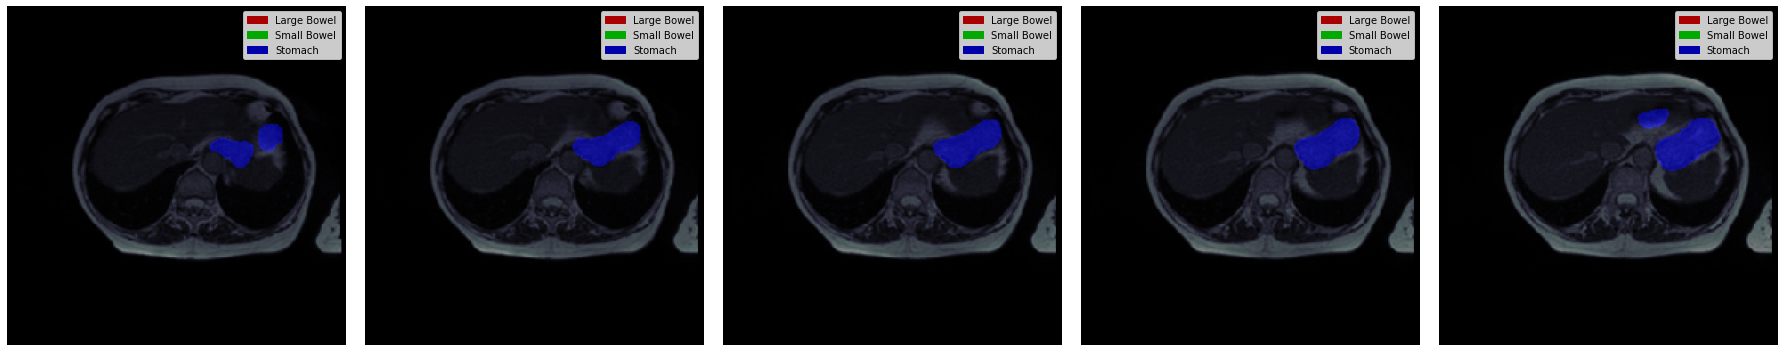

In [10]:
#!g1.1
valid_loader = prepare_loaders(fold=0, debug=True)
ip,mp,imgs, msks = next(iter(valid_loader))
imgs.size(), msks.size()
plot_batch(imgs, msks, size=5)

In [11]:
#!g1.1
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=CFG.input_chnls,    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [12]:
#!g1.1
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001, mean=True):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon))
    if mean: dice = dice.mean(dim=(1,0))
    return dice

In [75]:
#!g1.1
@torch.no_grad()
def do_valid(model, dataloader, device, mean=True):
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    df_val_scores = pd.DataFrame(columns=['image_path','mask_path','dice0','dice1','dice2'])
    
    dataloader_len = len(dataloader)
    
    pbar = tqdm(enumerate(dataloader), total=dataloader_len, desc='Valid ')
   
    for step, (ip,mp,images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        y_pred  = model(images)
        y_pred = nn.Sigmoid()(y_pred)
        
        val_dice = dice_coef(masks, y_pred,mean=mean).cpu().detach().numpy()
        df_rows = pd.DataFrame(columns=['image_path','mask_path','dice0','dice1','dice2'])
        df_rows.image_path = ip
        df_rows.mask_path = mp
        df_rows.dice0 = val_dice[:,0].tolist()
        df_rows.dice1 = val_dice[:,1].tolist()
        df_rows.dice2 = val_dice[:,2].tolist()
        
        #df_rows = pd.DataFrame([ip,mp,val_dice[:,0],val_dice[:,1],val_dice[:,2]], columns=['image_path','mask_path','dice0','dice1','dice2'] )
        df_val_scores = df_val_scores.append(df_rows, ignore_index=True)
        val_scores.append([ip,mp,val_dice,images.size(0)])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        pbar.set_postfix(gpu_memory=f'{mem:0.2f} GB')
        
    #val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
            
    return df_val_scores,val_scores

In [25]:
#!g1.1
model_path=EXPERIMENT_DIR+'best_valid-00_0.8978.bin'
model = load_model(model_path)
valid_loader = prepare_loaders(fold=0, debug=CFG.debug)

In [76]:
#!g1.1
df_val_scores, val_scores = do_valid(model,valid_loader,CFG.device,mean=False)

In [99]:
#!g1.1
df_val_scores['dice'] = (df_val_scores.dice0 + df_val_scores.dice1 + df_val_scores.dice2)/3.0

In [276]:
#!g1.1
df_dice_05_minus=pd.DataFrame((df_val_scores.query('dice<0.5')).reset_index())
df_dice_09_plus = pd.DataFrame((df_val_scores.query('dice>0.9')).reset_index())
df_dice_08_09 = pd.DataFrame((df_val_scores.query('dice>0.8 & dice<0.9')).reset_index())

df_dice_05_minus['im_metadata'] = df_dice_05_minus.image_path.str.replace('/home/jupyter/mnt/datasets/uw_dataset/png_img/uw-madison-gi-tract-image-segmentation/train/','')
df_dice_09_plus['im_metadata'] = df_dice_09_plus.image_path.str.replace('/home/jupyter/mnt/datasets/uw_dataset/png_img/uw-madison-gi-tract-image-segmentation/train/','')
df_dice_08_09['im_metadata'] = df_dice_08_09.image_path.str.replace('/home/jupyter/mnt/datasets/uw_dataset/png_img/uw-madison-gi-tract-image-segmentation/train/','')

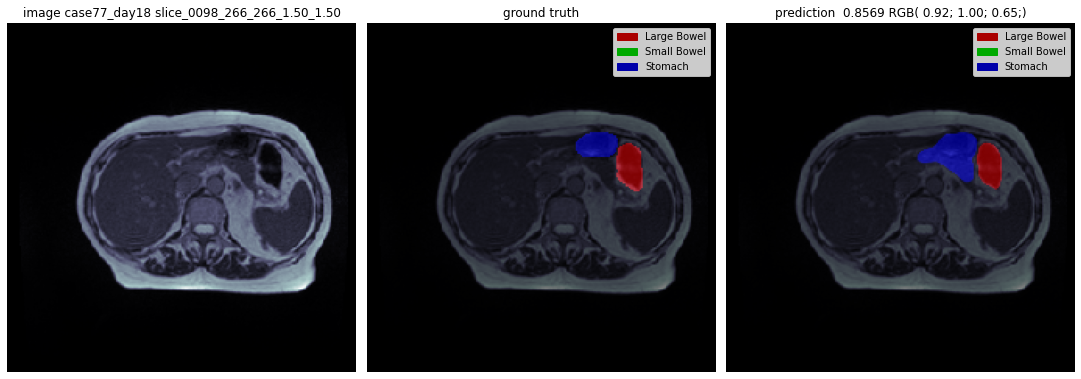

In [266]:
#!g1.1
def plot_gt_pr(img,msk_true,msk_pred,dice,meta):
    plt.figure(figsize=(100,10))
    ax0 = plt.subplot(1, 20, 1)
    ax0.set_title(f'image {meta[1]} {meta[3].replace(".png","")}')
    show_img(img)
    ax1 = plt.subplot(1, 20, 2)
    ax1.set_title('ground truth')
    show_img(img,msk_true)
    ax2 = plt.subplot(1, 20, 3)
    ax2.set_title(f'prediction {dice[0]: 0.4f} RGB({dice[1]: 0.2f};{dice[2]: 0.2f};{dice[3]: 0.2f};)')
    show_img(img,msk_pred)
    plt.tight_layout()
    plt.show()
    
def plot_a(df,index=0):
    img_path=df.image_path[index]
    msk_path=df.mask_path[index]
    dice = [df.dice[index],df.dice0[index],df.dice1[index],df.dice2[index]]
    meta = df.im_metadata[index].split('/')
    img = load_img(img_path)
    msk = load_msk(msk_path)
    img_t = np.transpose(img, (2, 0, 1))
    img_t=img_t[np.newaxis,:]
    p_msk = (nn.Sigmoid()(model((torch.tensor(img_t)).to(CFG.device, dtype=torch.float)))).detach().cpu().numpy()
    p_msk = np.transpose(p_msk[0],(1,2,0))
    plot_gt_pr(img,msk,p_msk,dice,meta)
plot_a(df_dice_08_09,10)

In [444]:
#!g1.1
df_meta=pd.DataFrame(df_dice_05_minus['im_metadata'])

In [449]:
#!g1.1
df_meta['slice'] = df_meta.im_metadata.str.split('/')


In [452]:
#!g1.1
df_meta['slice']  = df_meta.slice.str[3]

In [458]:
#!g1.1
df_meta['h'] = df_meta.slice.str.split('_').str[2].astype(int)
df_meta['w'] = df_meta.slice.str.split('_').str[3].astype(int)

In [460]:
#!g1.1
df_meta['h'].value_counts()

266    264
360    193
276      9
Name: h, dtype: int64

In [461]:
#!g1.1
df_meta['w'].value_counts()

266    264
310    193
276      9
Name: w, dtype: int64

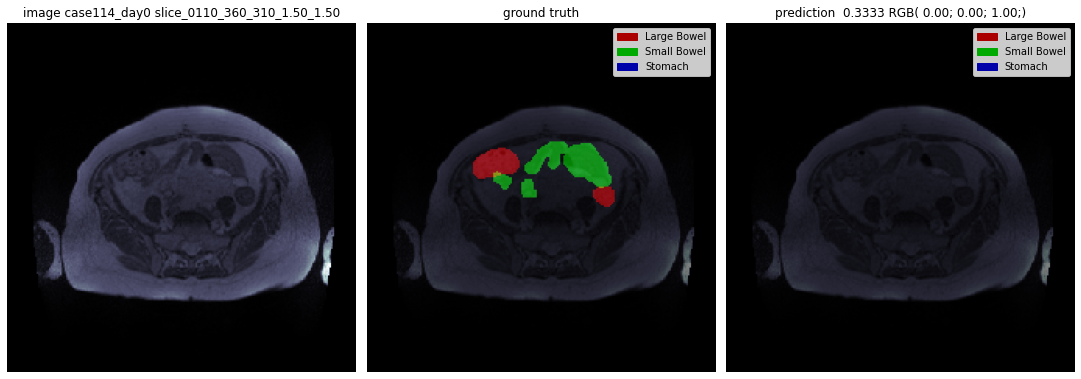

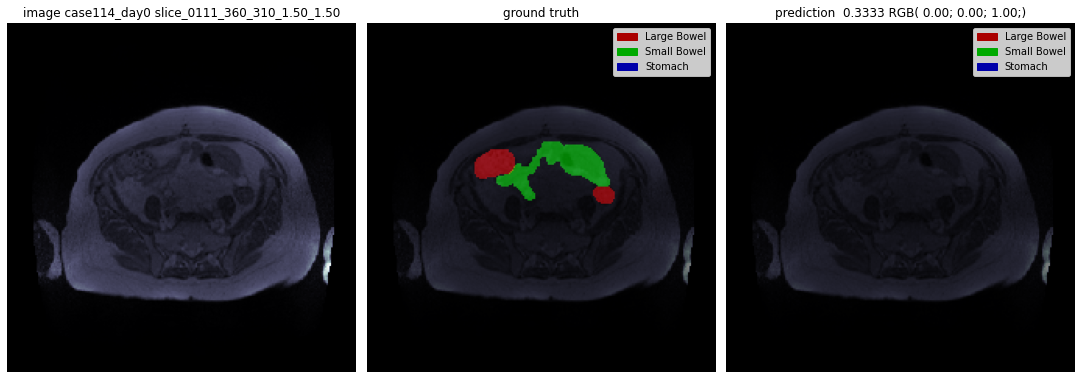

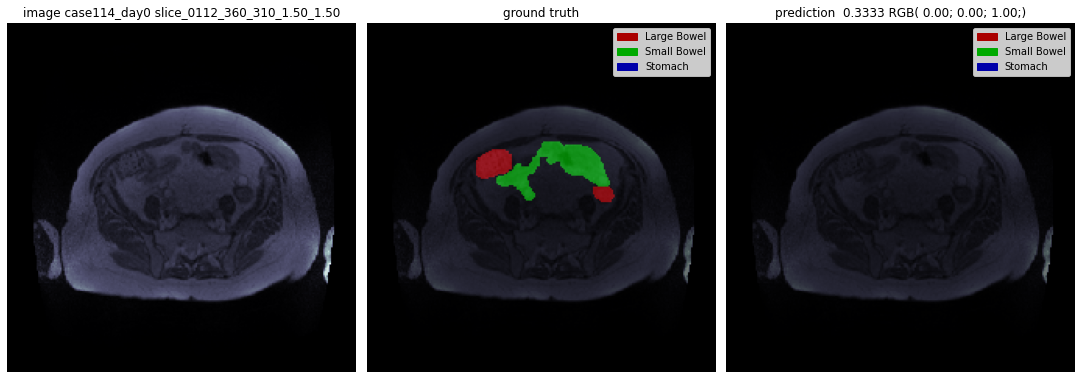

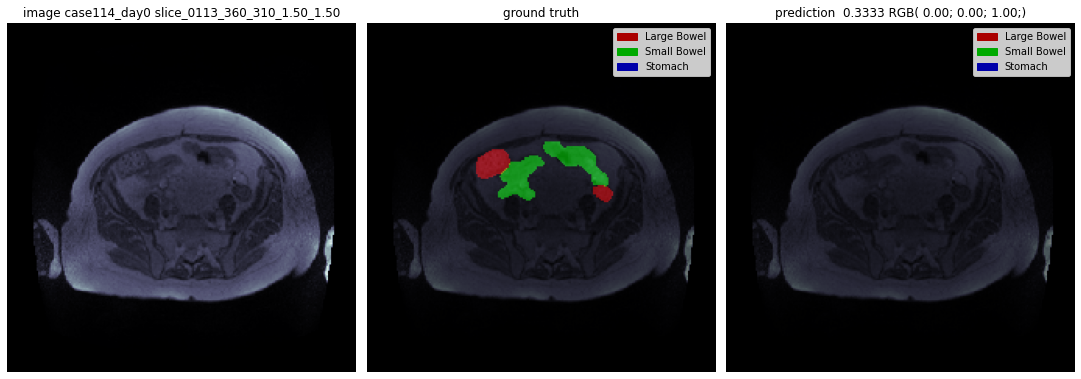

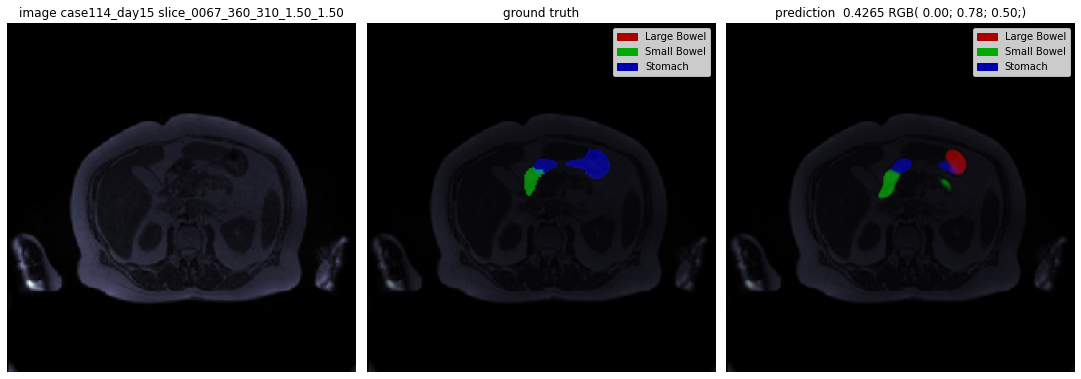

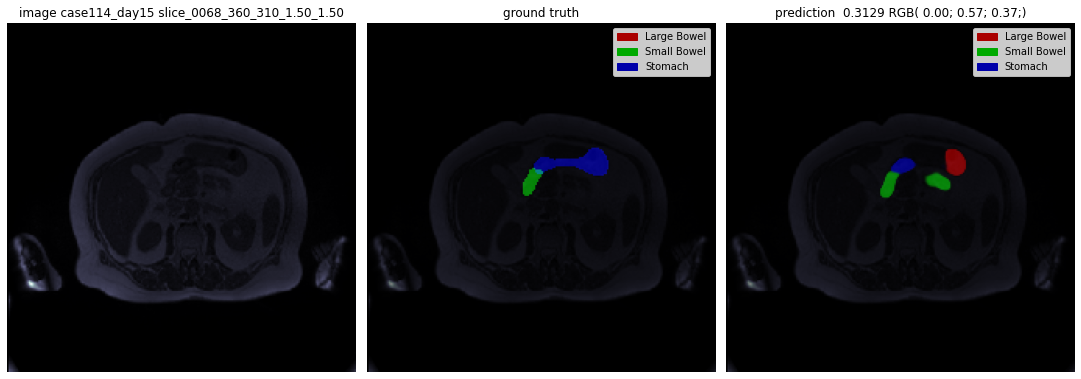

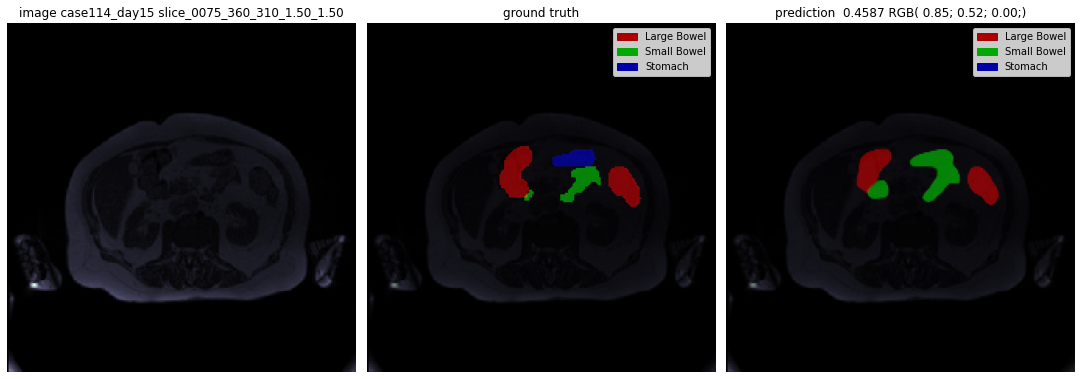

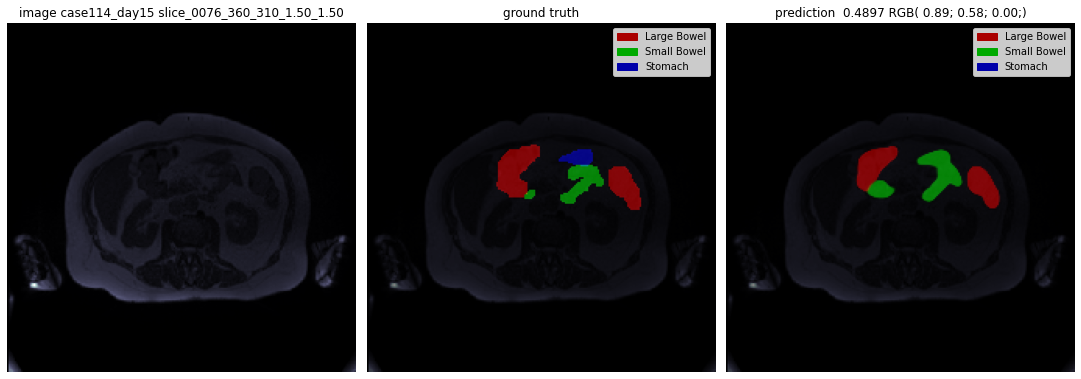

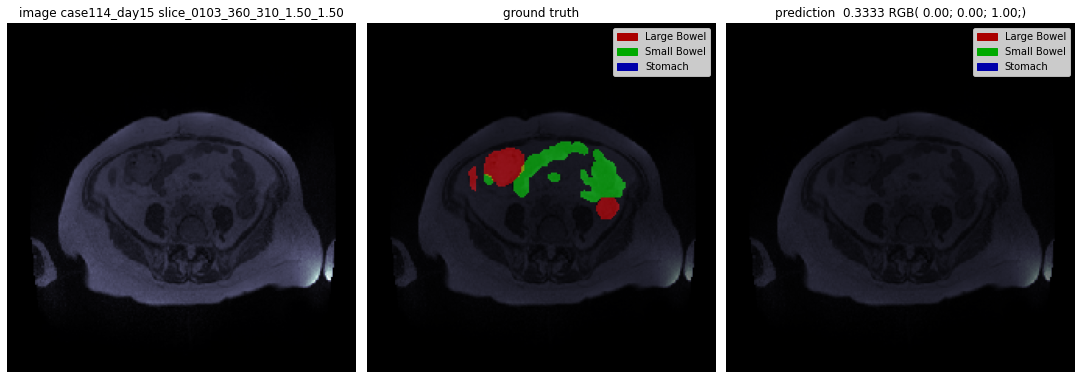

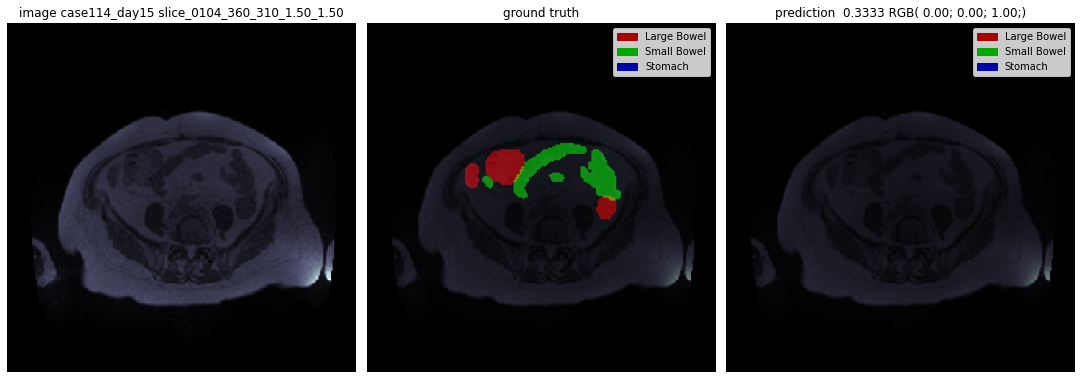

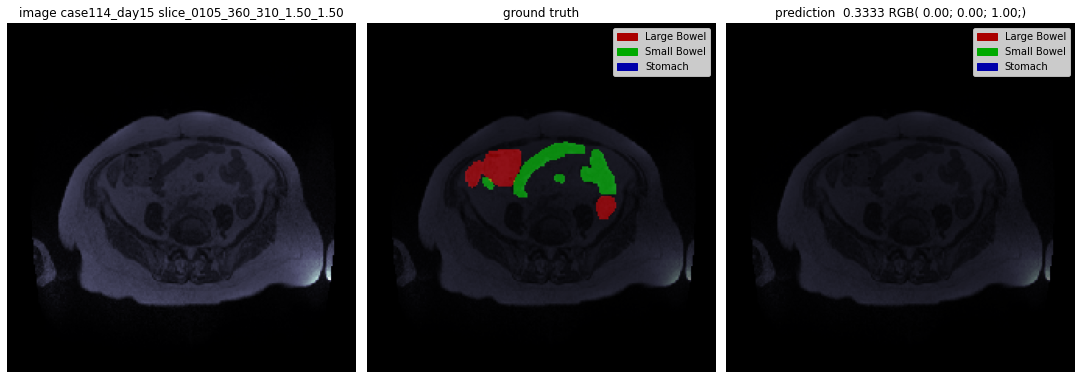

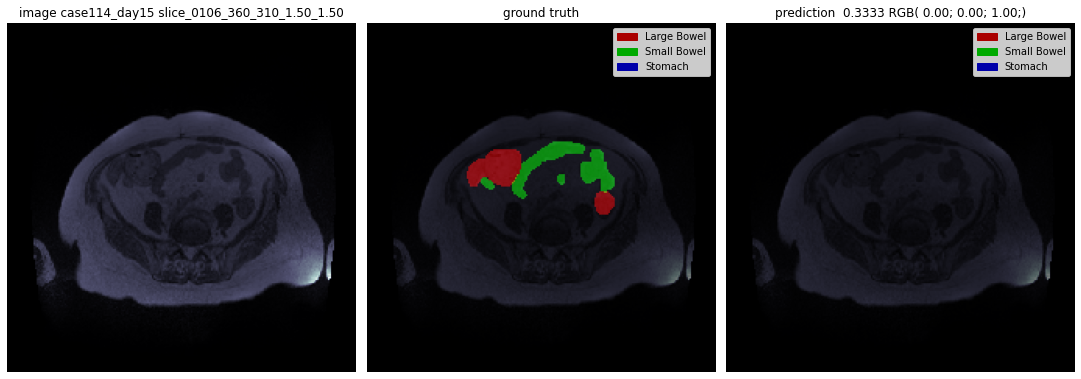

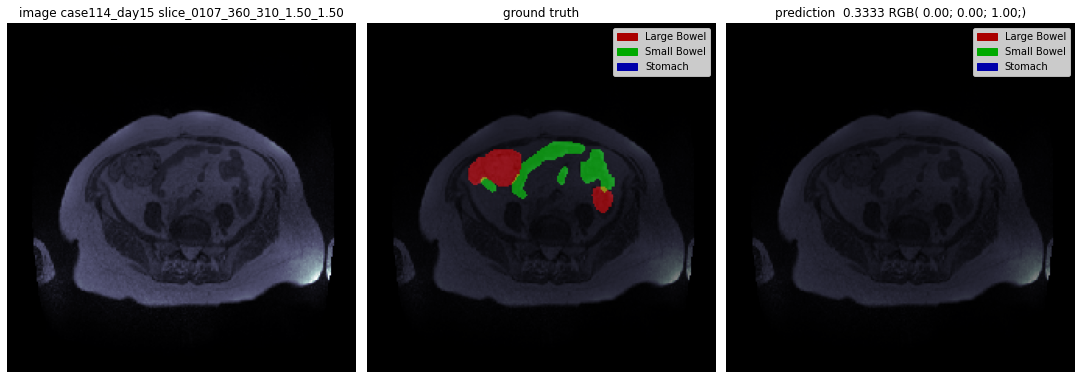

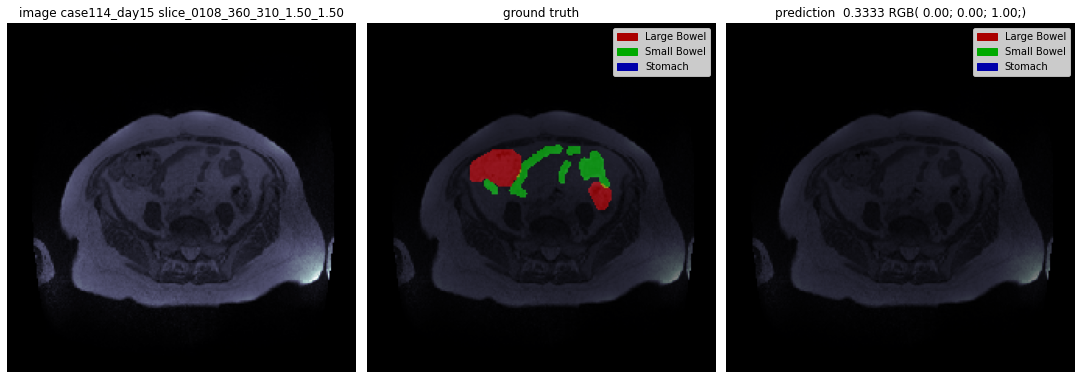

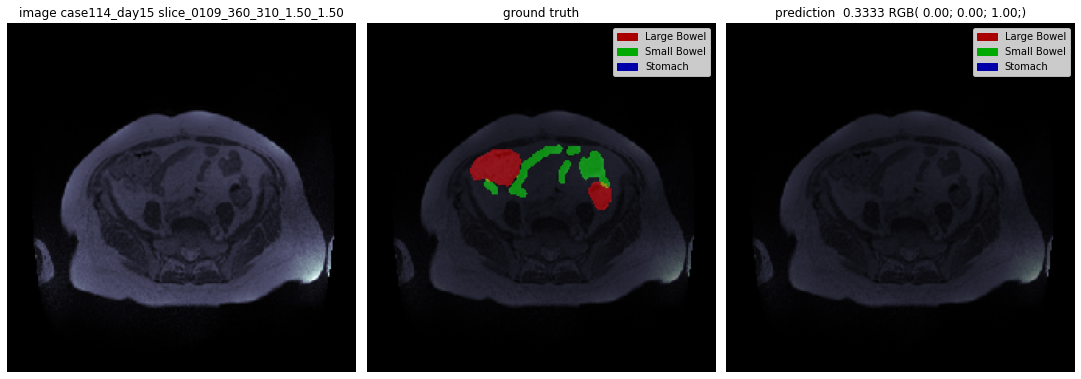

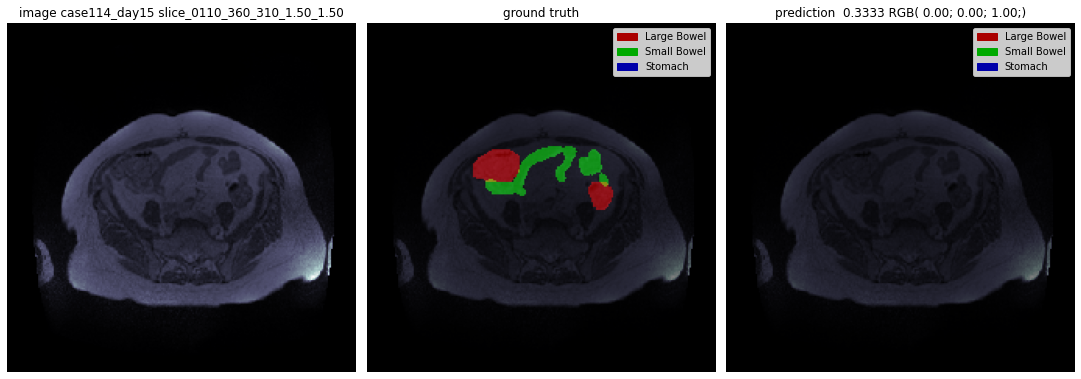

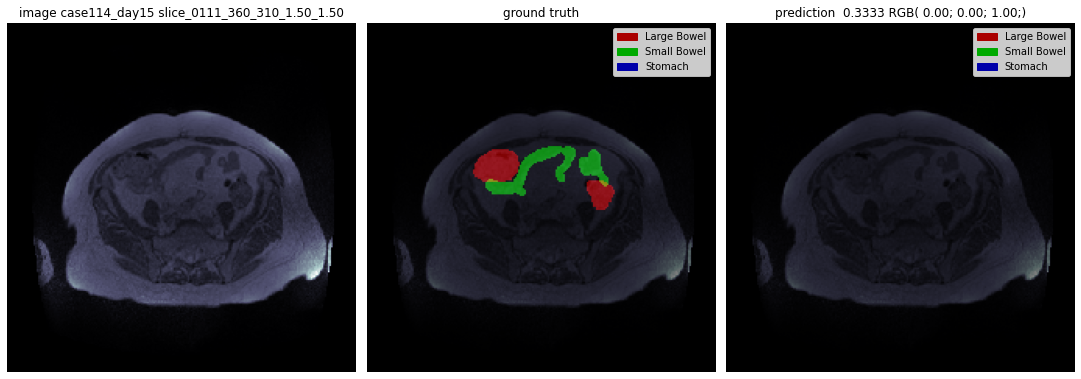

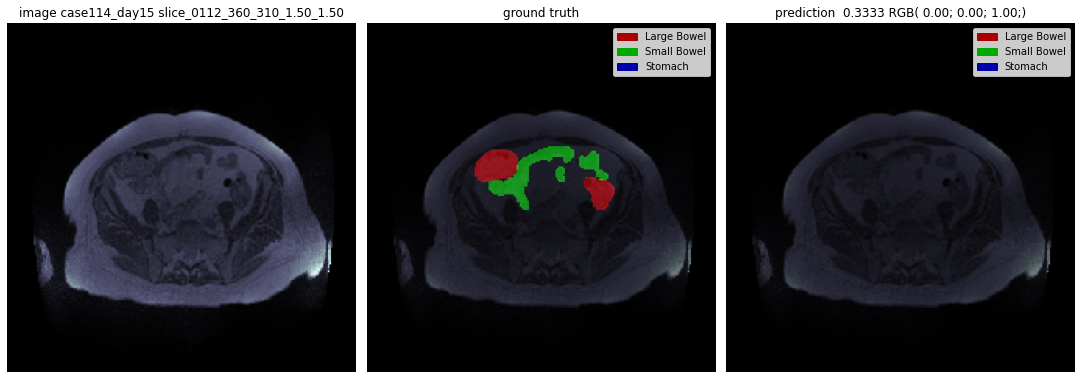

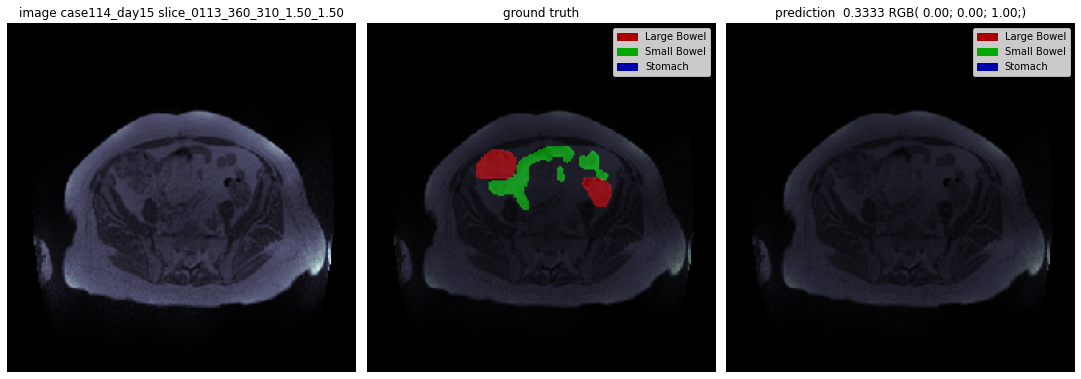

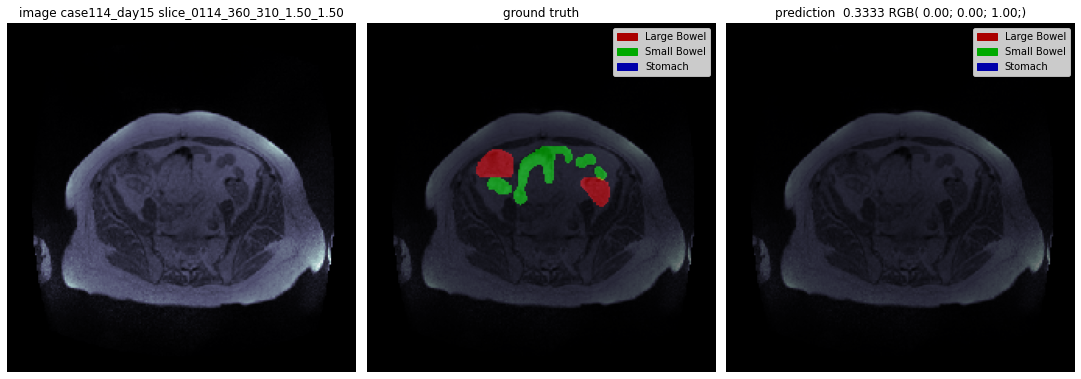

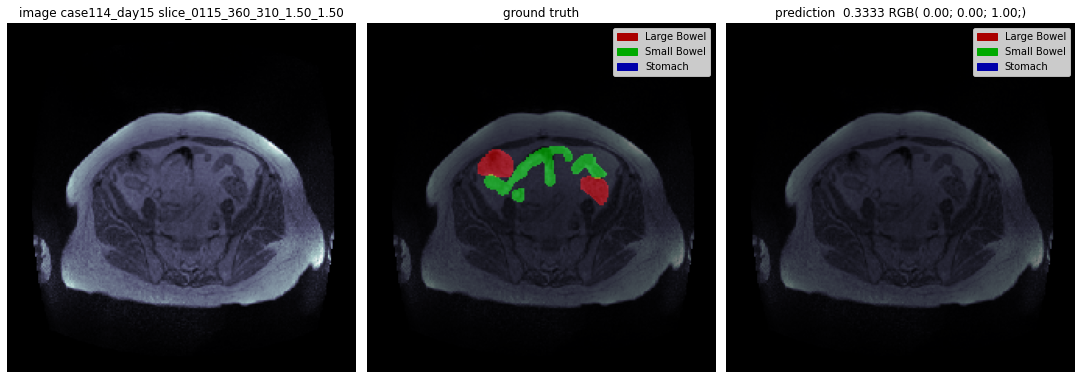

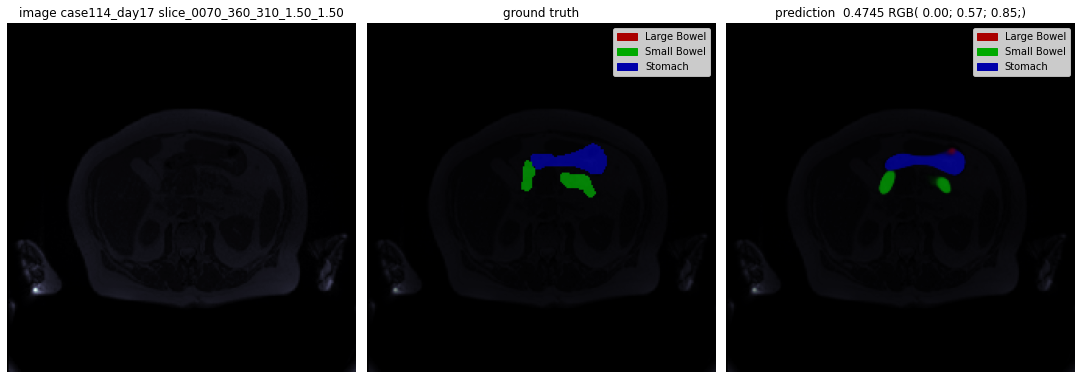

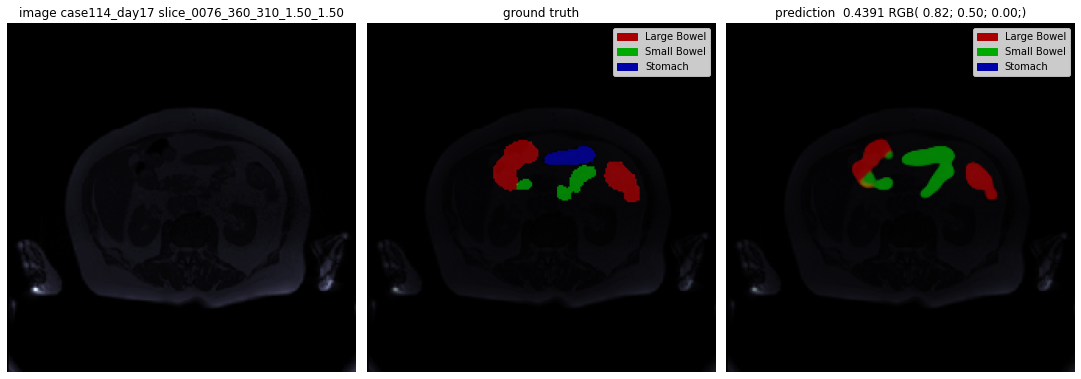

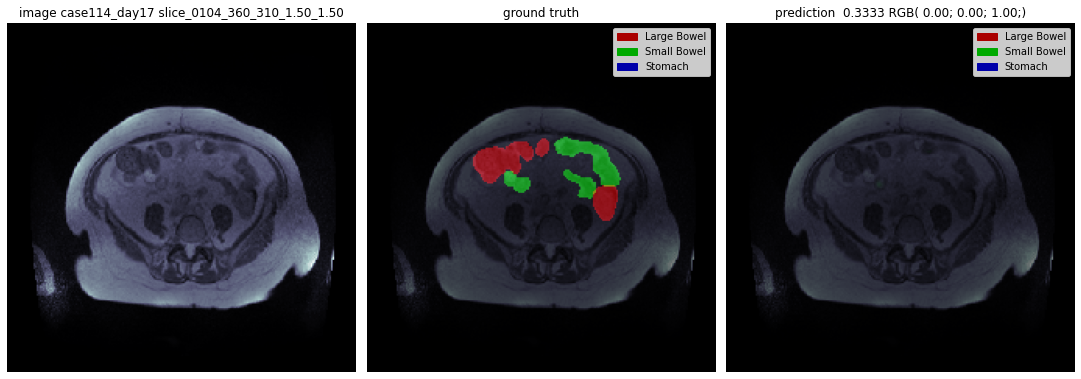

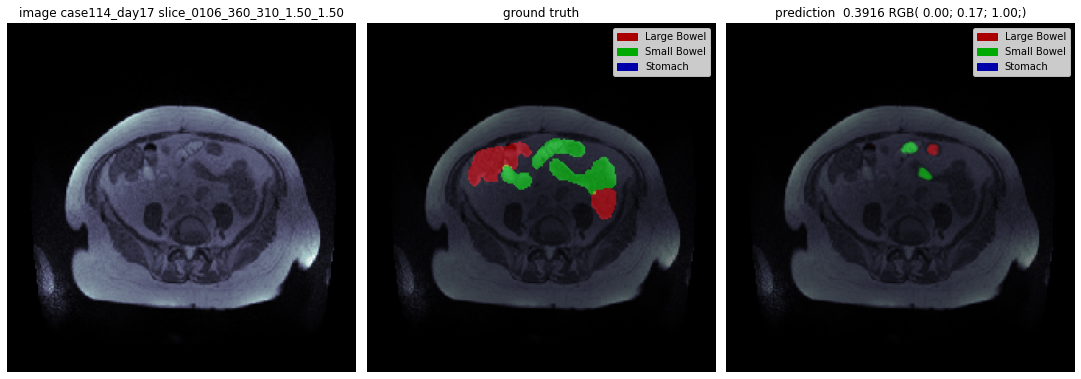

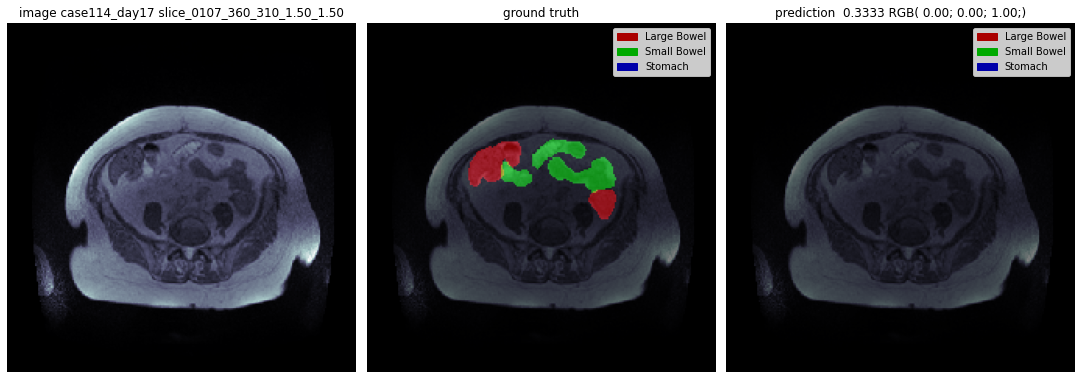

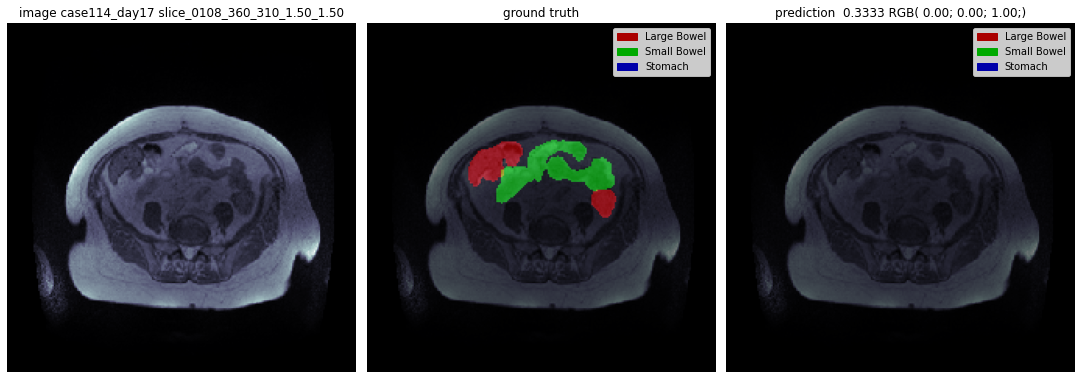

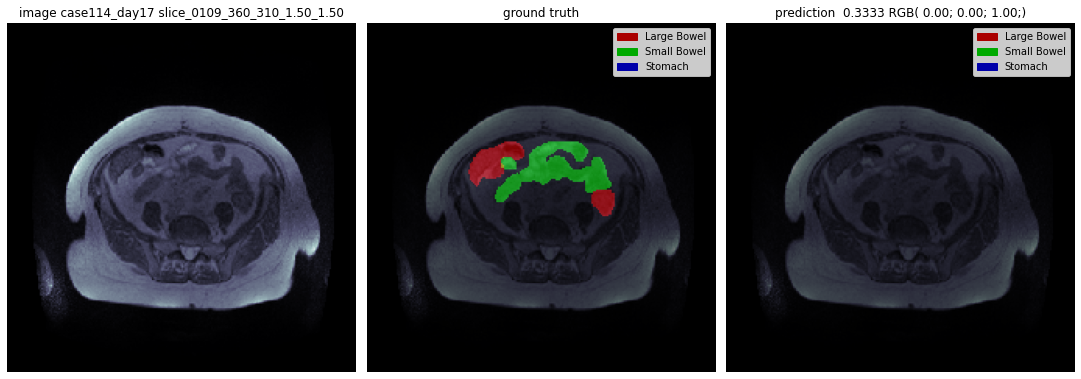

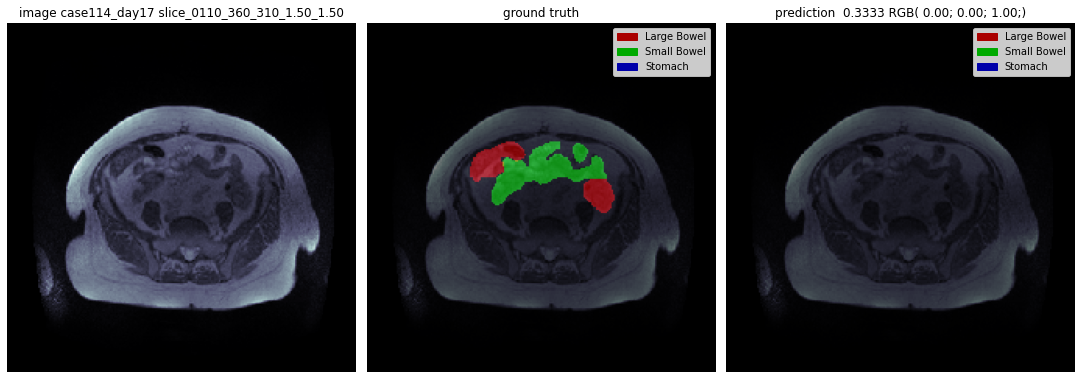

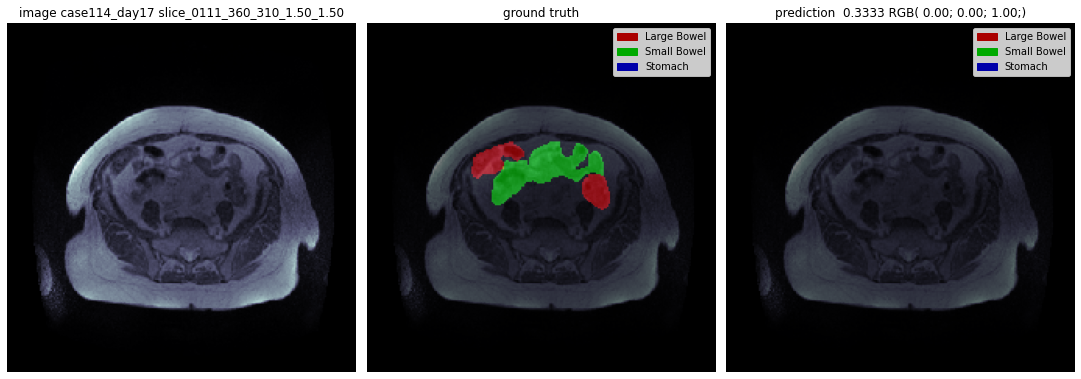

In [464]:
#!g1.1
for i in range(120,150,1):
    plot_a(df_dice_05_minus,i)

In [342]:
#!g1.1
df['slice']=df.id.str.split('_')

In [347]:
#!g1.1
df['slice']=df.slice.str[3]

In [349]:
#!g1.1
df['slice']=df['slice'].astype(int)

In [350]:
#!g1.1
pd.DataFrame(df.query('rle_len==0')['slice'].value_counts())

slice
1     272
2     271
6     270
3     270
4     270
..    ...
89      4
93      4
88      4
90      4
92      2

[144 rows x 1 columns]

In [338]:
#!g1.1
len(df.query('rle_len==0'))

21715

In [414]:
#!g1.1
df_sub =  pd.read_csv('submission.csv')
df_sub['slice']=df_sub.id.str.split('_')
df_sub['slice']=df_sub.slice.str[3]
df_sub['slice']=df_sub['slice'].astype(int)
df_sub_nan = pd.DataFrame(df_sub.query('(slice>0 & slice<45) | (slice>123 & slice<145)'))
df_sub_nan[~df_sub_nan['predicted'].isnull()]

id        class  \
2529  case77_day18_slice_0124  large_bowel   
2530  case77_day18_slice_0124  small_bowel   
2723  case133_day0_slice_0044      stomach   

                                              predicted  slice  
2529  39859 9 40125 9 40390 9 40656 8 40922 8 41189 ...    124  
2530  21732 3 21998 3 22264 3 22530 9 22794 16 23060...    124  
2723  39812 5 40169 11 40529 11 40889 14 41247 18 41...     44

In [411]:
#!g1.1
index = df_sub_nan[~df_sub_nan['predicted'].isnull()].index
df_sub.loc[index, 'predicted']=np.nan

In [406]:
#!g1.1
df_sub = df_sub.drop(['slice'], axis=1)
df_sub.head()

id        class predicted
0     case123_day20_slice_0001  large_bowel       NaN
1     case123_day20_slice_0001  small_bowel       NaN
2     case123_day20_slice_0001      stomach       NaN
3     case123_day20_slice_0002  large_bowel       NaN
4     case123_day20_slice_0002  small_bowel       NaN
...                        ...          ...       ...
2995   case133_day0_slice_0135  small_bowel       NaN
2996   case133_day0_slice_0135      stomach       NaN
2997   case133_day0_slice_0136  large_bowel       NaN
2998   case133_day0_slice_0136  small_bowel       NaN
2999   case133_day0_slice_0136      stomach       NaN

[3000 rows x 3 columns]

In [431]:
#!g1.1
def fix_empty_slices(_row):
    if _row["slice"] in remove_seg_slices[_row["class"]]:
        _row["predicted"] = np.nan
    return _row

In [423]:
#!g1.1
df_sub =  pd.read_csv('submission.csv')
df_sub['slice']=df_sub.id.str.split('_')
df_sub['slice']=df_sub.slice.str[3]
df_sub['slice']=df_sub['slice'].astype(int)

In [421]:
#!g1.1
remove_seg_slices = {
     "large_bowel": [1, 138, 139, 140, 141, 142, 143, 144],
    "small_bowel": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 138, 139, 140, 141, 142, 143, 144],
    "stomach": [1, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
}

In [432]:
#!g1.1
df_sub = df_sub.apply(fix_empty_slices, axis=1)

In [ ]:
#!g1.1
